In [1]:
from typing import Union, List, Tuple, Dict
from pydantic import BaseModel
import json
import pandas as pd
import re
from langchain.prompts import ChatPromptTemplate, PromptTemplate
from langchain_community.chat_models import ChatOllama
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import OllamaEmbeddings
from rag_tool_memory_save_noprint import run_filtered_rag
from Final_Trend import KeywordAnalyzer
from Final_evaluator import Agent3
from writer_tool4_new import generate_technical_draft


llm = ChatOllama(model="qwen2.5:7b", temperature=0.0)

def safe_result_summary(result):
    if isinstance(result, pd.DataFrame):
        return result.to_markdown(index=False)
    elif isinstance(result, list):
        return "\n".join(str(x) for x in result[:5]) 
    elif isinstance(result, dict):
        return json.dumps(result, indent=2, ensure_ascii=False)
    else:
        return str(result)


def extract_json_from_text(text: str) -> str:
    json_pattern = r'\{[\s\S]*\}'
    match = re.search(json_pattern, text)
    if match:
        return match.group(0)
    raise ValueError("JSON 형식이 아닙니다.")

# ✅ Embedding + Vectorstore 초기화
embedding_model = OllamaEmbeddings(model="bge-m3")
vectorstore = Chroma(
    persist_directory="D:/Capstone/chroma_db_final",
    embedding_function=embedding_model,
)

# ✅ 상태 정의
class PlanExecute(BaseModel):
    input: str
    tools: List[str] = []
    sub_queries: Dict[str, Union[str, List[str]]] = {}
    results: Dict[str, str] = {}
    response: Union[str, None] = None
    log: List[str] = []
    llm: ChatOllama = llm  # 전역 공유 LLM


# ✅ Tool Selector (도구 설명 포함)
tool_selector_prompt = ChatPromptTemplate.from_template("""
다음 사용자의 질문을 해결하기 위해 어떤 도구를 사용하는 것이 가장 적절한지 판단하세요.

[도구 설명]
- patent_searcher: 사용자의 기술적 질문에 맞는 특허를 검색하고 그 내용을 요약합니다.
- patent_trend_analyzer: 특정 키워드, 출원인을 기준으로 특허 출원 건수 및 트렌드를 시각화합니다.
- patent_evaluator: 주어진 기술 주제에 대한 특허들을 평가하기 위해 자사가 중요하게 보는 지표를 토대로 경쟁사의 중요 관련 특허들을 분석합니다.
- tech_writer: 기술 개요를 바탕으로 기술 설명서 초안을 작성합니다.

사용자의 질문:
"{query}"

✅ 선택 지침:
- 하나의 도구만 선택하는 것이 원칙입니다.
- 단, 질문이 두 개 이상의 도구가 협업해야만 해결되는 경우, 도구를 복수 선택하세요.
- patent_searcher의 경우 질문이 두 가지 이상의 고도화된 특허 검색이 요구되는 경우, patent_searcher를 두 번 반복 호출해도 됩니다.
- patent_searcher가 2번 선택된 경우는 **그리고**, **또는** 혹은 마침표나 콤마로 서로 다른 성격의 기술에 대해서 질문하는 경우에 두 번 호출하면돼.

반드시 아래와 같은 형태의 JSON 형식으로 응답하세요:
{{ "tools": ["patent_searcher"] }}
또는
{{ "tools": ["patent_searcher", "patent_evaluator"] }}                                                   
또는 사용자가 두 가지 상이한 기술적 내용 분석을 요구하는 경우,                                                        
{{ "tools": ["patent_searcher", "patent_searcher"] }}                                                        
또는
{{ "tools": ["patent_searcher", "patent_trend_analyzer"] }}
또는
{{ "tools": ["patent_searcher", "patent_trend_analyzer","patent_evaluator"]}}   
또는
{{ "tools": ["tech_writer"] }}                                                                                                                                                                       
""")
tool_selector_chain = tool_selector_prompt | llm

def tool_selector(state: PlanExecute):
    # 1) LLM 응답을 그대로 받고
    response = tool_selector_chain.invoke({"query": state.input})
    raw = response.content.strip()

    try:
        # 2) extract_json_from_text 로 JSON 덩어리만 추출
        json_text = extract_json_from_text(raw)
        parsed = json.loads(json_text)
    except Exception as e:
        # 3) 실패 시 디버깅을 위해 원본 응답 남기기
        raise ValueError(
            f"[tool_selector] JSON 파싱 실패: {e}\n"
            f"원본 응답:\n{raw}"
        )

    # 4) 잘 파싱된 tools 리스트로 상태 갱신
    return {
        "tools": parsed["tools"],
        "log": state.log + [f"🔧 선택된 도구: {parsed['tools']}"]
    }

# ✅ Sub-query Planner
sub_query_prompt = ChatPromptTemplate.from_template("""
다음은 사용자 질문과 선택된 도구 목록입니다.
각 도구에 대해 하나의 질의를 생성하세요. 
단,
- patent_searcher는 질문을 반영하여 기술적인 질문을 생성하여 전달, 이때 사용자가 기술적인 내용을 담기에 내용을 임의대로 누락하지 않았으면 해.**그리고** **또는** 및 마침표 콤마로 구분해서 두 가지 기술에 대해서 질문을 하는 경우는 나누어서 파악해.
- patent_trend_analyzer는 '**특허 출원 동향 분석**을 위해 사용자 sub query에 있는 키워드 단어와 연도를 사용해서 전달 (예1) 구동모터 관련 2020년 이후 출원 동향. 예2) 현대자동차의 배터리 관련 연도별 출원동향.)
- patent_evaluator는 경쟁사 및 특정 기술에 대한 평가를 위해 분석을 위한 키워드를 1~2개 사용해서 전달. 이때 키워드는 기술 단위여야하고 자연어 형태로 전달해야함.
- tech_writer는 "초안작성" 이라고 전달.
                                                    
사용자의 질문:
"{query}"

선택된 도구 목록:
{tools}

                                                    
복합 질의의 경우 출력 예시:
1) 사용자의 쿼리가 "전기차의 배터리 효율 개선 기술 관련 특허있어? 관련 기술에 대한 연도별 출원 동향도 알려줘"라면,
{{
  "sub_queries": {{
    "patent_searcher": "전기차의 배터리 효율 개선 기술 관련 특허",
    "patent_trend_analyzer": "전기차과열 방지 관련 연도별 출원 동향"
  }}
}}
또는
2) 사용자의 쿼리가 "전기차 내 냉각수 흐름을 제어하기 위해 구축한 자동 모니터링 기술을 알고 싶고 열을 관리하기 위해 내부 쿨링시스템을 이용하는 기술을 알고 싶다" 고 한다면, 두 가지 기술 핵심 내용이 들어있으므로,
{{
  "sub_queries": {{
    "patent_searcher": "전기차 내 냉각수 흐름을 제어하기 위해 구축한 자동 모니터링하는 기술, 열 관리를 위한 차체 내 쿨링 시스템을 이용하는 기술",
  }}
}}
또는                                                    
3) 사용자의 쿼리가 "전기차의 변속감을 좋게 하기 위해 등장한 특허 있어? 관련 기술을 출원한 현대자동차의 특허 평가를 해줘"라면,
{{
  "sub_queries": {{
    "patent_searcher": "변속감을 주며 승차감을 높인 기술",
    "patent_evaluator": "변속감 및 속도 제어 "
  }}
}}
형식으로 출력하세요.                                                                                                                                                       
""")
sub_query_chain = sub_query_prompt | llm

def tool_query_planner(state: PlanExecute):
    tools_str = ", ".join(state.tools)
    result = sub_query_chain.invoke({"query": state.input, "tools": ", ".join(state.tools)})
    
    try:
        json_text = extract_json_from_text(result.content)
        parsed = json.loads(json_text)
    except Exception as e:
        raise ValueError(f"❌ Sub-query 생성 결과 파싱 실패:\n{result.content}\n\n에러: {e}")
    
    print(f"Sub-query 분리 결과: {parsed['sub_queries']}")

    return {
        "sub_queries": parsed["sub_queries"],
        "log": state.log + [f"🧩 Sub-query 분리 결과: {parsed['sub_queries']}"]
    }

# ✅ Tool 실행기
def execute_tools(state: PlanExecute):
    results = {}
    for tool_name, query in state.sub_queries.items():
        if tool_name == "patent_searcher":
            sub_queries = [q.strip() for q in query.split(",") if q.strip()]  # 쉼표 기준 분리
            combined_summary = ""
            for i, sub_q in enumerate(sub_queries, 1):
                # print(f"\n🔍 [Tool1-{i}] 서브 쿼리 실행 중: {sub_q}")
                summary, _ = run_filtered_rag(vectorstore, embedding_model, sub_q, llm=state.llm, use_bm25=True)
                combined_summary += f"[서브 쿼리 {i}] {sub_q}\n{summary}\n\n"
            results[tool_name] = combined_summary.strip()


        elif tool_name == "patent_trend_analyzer":
            trend_agent = KeywordAnalyzer(csv_path="0527_cleaning_processing_ver1.csv", llm=state.llm)
            intepretation = trend_agent.run(query) 
            results[tool_name] = safe_result_summary(intepretation)
        elif tool_name == "patent_evaluator":
            evaluator = Agent3(
                csv_path="D:/Capstone/0527_cleaning_processing_ver1.csv",
                llm=state.llm
            )
            interpretation = evaluator.handle(topic_query=query)
            results[tool_name] = interpretation  # 바로 시사점 결과 저장
        elif tool_name == "tech_writer":
            print("📝 기술 설명서를 위한 초안 작성을 시작합니다.")
            results[tool_name] = generate_technical_draft.invoke({"user_input": query})  
        else:
            results[tool_name] = f"[{tool_name}]에 대한 응답 (Mock 처리됨)"
            
    return {
        "results": results,
        "log": state.log + [f"⚙️ 실행 완료: {list(results.keys())}"]
    }

# ✅ 결과 요약기
def post_summary(state: PlanExecute):
    merged = "\n\n".join(f"[{tool} 결과]\n{res}" for tool, res in state.results.items())
    summary_prompt = PromptTemplate.from_template("""
아래는 각 도구를 통해 수집된 결과입니다:

{merged}

이 정보를 바탕으로 사용자의 질문에 대한 종합적인 답변을 자연스럽게 작성하세요.
이때, 각 Tool에 따라 어떤 정보가 파악되었는지, 이를 통해 어떤 종합적 시사점을 얻을 수 있는지의 형식으로 출력할 수 있습니다.
- 단,다른 언어라면 **반드시** 한국어로 변환해서 출력하세요.
""")
    summary_chain = summary_prompt | state.llm
    result = summary_chain.invoke({"merged": merged})
    return {
        "response": result.content.strip(),
        #"log": state.log + ["🧠 최종 종합 요약 완료"]
    }

# ✅ LangGraph 구성
graph = StateGraph(PlanExecute)
graph.add_node("tool_selector", tool_selector)
graph.add_node("tool_query_planner", tool_query_planner)
graph.add_node("execute", execute_tools)
graph.add_node("post_summary", post_summary)

graph.add_edge(START, "tool_selector")
graph.add_edge("tool_selector", "tool_query_planner")
graph.add_edge("tool_query_planner", "execute")
graph.add_edge("execute", "post_summary")
graph.add_edge("post_summary", END)

app = graph.compile(checkpointer=MemorySaver())

C:\Users\SEONGSOO\AppData\Local\Temp\ipykernel_31244\952549307.py:18: LangChainDeprecationWarning: The class `ChatOllama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import ChatOllama``.
  llm = ChatOllama(model="qwen2.5:7b", temperature=0.0)
C:\Users\SEONGSOO\AppData\Local\Temp\ipykernel_31244\952549307.py:39: LangChainDeprecationWarning: The class `OllamaEmbeddings` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaEmbeddings``.
  embedding_model = OllamaEmbeddings(model="bge-m3")
C:\Users\SEONGSOO\AppData\Local\Temp\ipyker

### Tool1 + Tool3 (Multiple Query)

In [2]:
result = app.invoke(
    {"input": "현대케피코가 2020년 이후에 출원한 최적 운전점을 정하는 방법에 관련된 기술 검색해주고, 관련해서 엔진 토크 효율관리에 대한 중요 특허 평가해줘."},
    config={"configurable": {"thread_id": "demo-thread"}}
)
# print("\n📝 전체 실행 로그:")
# for i, entry in enumerate(result["log"], 1):
#     print(f"\nStep {i}:")
#     print(entry)
print("\n📄 최종 결과:")
print(result.get("response", "[응답 없음]")) # Streamlit 최종 output!

Sub-query 분리 결과: {'patent_searcher': '현대케피코가 2020년 이후에 출원한 최적 운전점을 정하는 방법, 엔진 토크 효율 관리', 'patent_evaluator': '엔진 토크 효율 관리'}


d:\Capstone\rag_tool_memory_save_noprint.py:354: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  filter_chain = LLMChain(llm=llm, prompt=filtering_prompt)
d:\Capstone\rag_tool_memory_save_noprint.py:356: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  parsed_filter = json.loads(extract_json_from_text(filter_chain.run(query=user_query)))
d:\Capstone\rag_tool_memory_save_noprint.py:382: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  sparse_docs = sparse_retriever.get_relevant_documents(user_query)



📘 특허 검색 및 요약 정보:

현대케피코는 2020년 이후에 출원한 '하이브리드 전기 차량의 최적 운전점 제어 방법 및 그 장치'라는 특허(KR20200179807A)를 통해, 하이브리드 전기 차량에서 최적 운전점을 정하는 방법을 제시하였습니다.

본 발명은 기존의 하이브리드 전기 차량에서 엔진과 모터가 함께 동작할 때, 최적의 운전점 선정에 있어 등가 BSFC(equivalent Brake Specific Fuel Consumption)를 기준으로 하는 방식을 도입하였습니다. 이는 충전 상황과 방전 상황을 구분하여 각각에 대한 최적 엔진 토크를 산출하고, 이를 통해 운전자의 가속 요구나 Auto Cruise Mode 등에 따른 동작을 결정합니다.

이러한 기술은 하이브리드 전기 차량의 연비 효율을 개선하는 데 크게 기여하며, 특히 엔진 클러치 직결 상태에서 모터와 엔진 RPM이 동일하고 토크 분배가 용이하다는 점에서 유리합니다. 또한, 이 방법은 비효율적인 엔진 구동을 피하여 펌핑 손실(Pumping Loss)을 줄이는 데에도 효과적입니다.

따라서, 현대케피코의 특허는 하이브리드 전기 차량에서 연비 효율을 최적화하는 동시에, 다양한 운전 상황에 대응할 수 있는 방법을 제시함으로써 기존의 문제를 해결하고 있습니다.

 관련 특허 요약 정보:

| 출원번호       | 발명의 명칭                                                                            | 요약                                                                                                                                                                                                                                                       

In [3]:
result = app.invoke(
    {"input": "높은 기울기 상태에서 급출발시 차량 밀림 현상이 발생할 수 있는데 이를 보완한 개선 기술이라던지"},
    config={"configurable": {"thread_id": "demo-thread"}}
)
print("\n📝 전체 실행 로그:")
for i, entry in enumerate(result["log"], 1):
    print(f"\nStep {i}:")
    print(entry)

print("\n📄 최종 결과:")
print(result.get("response", "[응답 없음]"))

Sub-query 분리 결과: {'patent_searcher': '높은 기울기 상태에서 급출발시 차량 밀림 현상이 발생할 수 있는 개선 기술', 'patent_evaluator': '차량 밀림 현상을 보완한 기술'}

📘 특허 검색 및 요약 정보:

출원번호: KR20230156001A
출원인: 현대자동차
발명의 명칭: 전기자동차의 런치 컨트롤 시스템 및 방법

이 특허는 전기차에서 높은 기울기 상태에서 급출발시 차량 밀림 현상을 개선하기 위해 제안되었습니다. 기존의 전동차에서는 높은 기울기 상태에서 급출발 시, 특히 전륜 모터와 후륜 모터 간의 토크 분배가 불균형하여 차량이 밀릴 수 있는 문제가 있었습니다.

특허는 이를 해결하기 위해 차량 제어기(VCU)를 통해 전륜 모터(31)와 후륜 모터(32)에 대한 토크 지령을 효율적으로 관리합니다. 또한, 배터리 관리 시스템(BMS)과의 통신을 통해 배터리의 가용 파워 및 충전 상태를 고려하여 최적의 토크 분배를 수행합니다.

차량 제어기(VCU)는 전륜 모터(31)와 후륜 모터(32)로부터 실출력토크, 가용토크 등을 수신하고, 이를 바탕으로 토크 지령치를 결정합니다. 이 과정에서 가속페달 입력 신호, 브레이크 페달 입력 신호 및 변속단 입력 신호 등 다양한 정보가 고려되어, 차량의 밀림 현상을 최소화하고 안전한 출발을 보장합니다.

이렇게 하여, 이 특허는 전기차에서 높은 기울기 상태에서 급출발 시 발생하는 차량 밀림 문제를 해결하며, 안정적인 주행 성능을 제공합니다.

 관련 특허 요약 정보:

| 출원번호       | 발명의 명칭                                                               | 요약                                                                                                                                                   

In [2]:
result = app.invoke(
    {"input": "하이브리드 차나 전기차가 연비가 내연기관보다 안좋은데 이를 극복하기 위해서 어떤 게 등장했어?"},
    config={"configurable": {"thread_id": "demo-thread"}}
)
print("\n📝 전체 실행 로그:")
for i, entry in enumerate(result["log"], 1):
    print(f"\nStep {i}:")
    print(entry)

print("\n📄 최종 결과:")
print(result.get("response", "[응답 없음]"))

Sub-query 분리 결과: {'patent_searcher': '내연기관보다 안좋은 연비를 극복하기 위한 기술'}


d:\Capstone\rag_tool_memory_save_noprint.py:354: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  filter_chain = LLMChain(llm=llm, prompt=filtering_prompt)
d:\Capstone\rag_tool_memory_save_noprint.py:356: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  parsed_filter = json.loads(extract_json_from_text(filter_chain.run(query=user_query)))
d:\Capstone\rag_tool_memory_save_noprint.py:382: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  sparse_docs = sparse_retriever.get_relevant_documents(user_query)



📘 특허 검색 및 요약 정보:

출원번호: KR20237004742A
출원인: 발레오 파워트레인 (난징) 컴퍼니 리미티드
발명의 명칭: 전기 자동차용 통합 드라이브트레인 조립체 및 전기 자동차

이 특허는 전기 자동차용 통합 드라이브트레인 조립체와 이를 포함하는 전기 자동차에 관한 것으로, 기존의 내연기관 차량보다 안좋은 연비를 극복하기 위한 솔루션을 제시하고 있습니다. 배경기술에서는 환경 문제와 연료 비용 증가로 인해 저공해 자동차 개발이 급증하였으며, 특히 BEV, HEV 등 전기 자동차의 성능과 효율성을 높이는 데 중점을 두고 있습니다.

전기 자동차는 열 발생을 줄일 수 있지만, 고출력 BEV 같은 경우 드라이브트레인 시스템에 적어도 2개의 냉각 회로가 필요하며 이는 복잡하고 비용이 많이 들었습니다. 이러한 문제를 해결하기 위해 발명자는 전기 자동차용 드라이브트레인 시스템의 냉각 설계를 개선하려고 노력했습니다.

발명은 전체 시스템에 대해 오일 냉각만을 사용함으로써, 인버터가 오일에 의해 효율적으로 냉각될 수 있도록 하는 것을 목표로 합니다. 이를 통해 전기 자동차의 성능과 효율성을 향상시키는 동시에, 비용 절감 효과를 얻을 수 있습니다. 이는 내연기관 차량보다 안좋은 연비를 극복하기 위한 중요한 기술적 발전으로 평가될 수 있습니다.

이와 관련하여, 전기 자동차의 냉각 시스템 설계에서 오일 냉각과 수냉 방식을 병행하는 대신 단순화된 오일 냉각만을 사용함으로써, 비용 효율성을 향상시키는 효과를 얻을 수 있습니다. 이러한 발명은 전기 자동차의 성능과 효율성 향상을 동시에 달성하면서도, 전체 시스템의 복잡성을 줄이고 비용을 절감하는 데 기여합니다.

 관련 특허 요약 정보:

| 출원번호       | 발명의 명칭                                                                      | 요약                                                               

In [ ]:
result = app.invoke(
    {"input": "전기차 화재 사고에 대응해서 화재가 일어날 경우 이를 방지하기 위해 도입된 기술이 있어?"},
    config={"configurable": {"thread_id": "demo-thread"}}
) # Streamlit 최종 output!

# print("\n📝 전체 실행 로그:")
# for i, entry in enumerate(result["log"], 1):
#     print(f"\nStep {i}:")
#     print(entry)
print("\n📄 최종 결과:")
print(result.get("response", "[응답 없음]"))

Sub-query 분리 결과: {'patent_searcher': '전기차 화재 사고에 대응해서 화재가 일어날 경우 이를 방지하기 위해 도입된 기술'}

📘 특허 검색 및 요약 정보:

전기차 화재 사고에 대응하기 위해 도입된 다양한 기술들이 있습니다. 먼저, 출원번호 KR20240019214A의 '전기차 충전중 화재 예방 및 진화'는 전기차가 주정차하거나 충전 중인 시점부터 온도 관제를 시작하여 화재를 예방하고 초기 진화에 도움을 줍니다. 이 기술은 센서와 소화설비의 자동화를 통해 무인현장에서도 프로세스에 따른 신속한 조치가 가능하며, 지상과 지하 등 다양한 장소에서 운영할 수 있습니다.

다음으로, 출원번호 KR20240061943A의 '인공지능 및 열화상 센서를 이용한 주차장 전기차 화재 관제시스템'은 주차장에 진입하는 전기차를 인식하고 지속적으로 감시합니다. 이 시스템은 머신러닝 기술을 활용하여 화재 발생 가능성을 예측하고, 이를 통해 사전 방지와 최적의 화재 관제를 수행할 수 있습니다.

마지막으로, 출원번호 KR20240049084A의 '전기차 화재 방재 장치'는 전기차 화재가 발생한 경우, 해당 주차구획을 식별하고 차수벽을 형성하여 소화수를 주입합니다. 이를 통해 배터리를 소화수에 담가 온도를 낮추어 화재를 조기에 진화시키는 효과가 있습니다.

이러한 기술들은 각각의 특징과 장점을 가지고 있으며, 전기차 화재 사고 예방 및 초기 진화에 중요한 역할을 합니다. 센서와 자동화 설비, 인공지능 기반 감시 시스템, 그리고 직접적인 화재 진화 장치가 결합되어, 전기차 화재로 인한 물적 손해를 최소화하고 인명 피해를 줄이는 데 효과적입니다. 이러한 기술들은 지속적으로 발전하며, 미래의 안전성과 효율성을 향상시키는 중요한 역할을 수행하게 될 것입니다.

 관련 특허 요약 정보:

| 출원번호       | 발명의 명칭                                                                            | 요약 

### Tool 1의 중복 선택 (Replan 관점)

In [6]:
result = app.invoke(
    {"input": "전기차 과열에 따른 문제 방지를 위해서 쿨링은 필수적인데 이를 위해 차량 자체의 에너지를 이용하는 기술 있어? 그리고 이런 과열 때문에 전기차에서 화재가 발생하곤 하잖아. 이를 방지하기 위한 기술은 요즘 뭐가 있어?"},
    config={"configurable": {"thread_id": "demo-thread"}}
)
print("\n📝 전체 실행 로그:")
for i, entry in enumerate(result["log"], 1):
    print(f"\nStep {i}:")
    print(entry)

print("\n📄 최종 결과:")
print(result.get("response", "[응답 없음]"))

Sub-query 분리 결과: {'patent_searcher': '전기차에서 화재를 방지하기 위한 최신 기술', 'patent_trend_analyzer': '전기차와 관련한 과열 및 화재 예방 기술의 연도별 출원 동향'}

🔍 [Tool1-1] 서브 쿼리 실행 중: 전기차에서 화재를 방지하기 위한 최신 기술
🔍 추론된 필터 조건: {}

🔎 총 retrieval 문서 수: 10개
[🔹 Retrieved 1] KR20250008953A | 엘지에너지솔루션 | 전기차 충전 스테이션을 이용한 배터리 성능관리 시스템 및 방법 | Section: 요약
[🔹 Retrieved 2] KR20240192379A | (주)그린파워 | 전기차 배터리 화재진압시스템 | Section: 요약
[🔹 Retrieved 3] KR20240049084A | 선포탈 | 전기차 화재 방재 장치 | Section: 기술배경
[🔹 Retrieved 4] KR20240019214A | 손희창 | 전기차 충전중 화재 예방 및 진화 | Section: 발명의효과
[🔹 Retrieved 5] KR20240000161A |  | 전기차량의 화재 진압 장치 | Section: 기술배경
[🔹 Retrieved 6] KR20230121363A | 동의과학대학교산학협력단 | 온도 감응형 밴드를 이용한 전기자동차 화재 감시시스템 | Section: 기술배경
[🔹 Retrieved 7] KR20230111816A | 티이 커넥티비티 솔루션스 게엠베하 | 전류를 전달하기 위한 표면 상의 코팅 | Section: 기술배경
[🔹 Retrieved 8] KR20230065791A | (주) 아하 | 전기차 충전소 화재 감지 및 화재 처리 시스템 | Section: 기술과제
[🔹 Retrieved 9] KR20230032645A | (주)에바 | 전기차 화재 발생 감지 시스템과 이를 이용한 전기차 화재 발생 감지 방법 | Section: 기술배경
[🔹 Retrieved 10] KR20230016740A | 리크텍 | 전

### Tool1 + Tool2(Multi Query) 

Sub-query 분리 결과: {'patent_searcher': '태양광을 이용하여 이차전지로 전기자동차 충전을 가능하게 하는 기술, 듀얼 배터리 기술', 'patent_trend_analyzer': '현대자동차의 태양광 관련 연도별 출원 동향'}

📘 특허 검색 및 요약 정보:

태양광을 이용하여 이차전지로 전기자동차 충전을 가능하게 하는 기술은 두 가지 특허에서 다루어졌습니다. 

먼저, 특허 KR20230009198A는 '계통 전력과 태양광 발전부 및 배터리 관리부의 연계를 통한 전기자동차 충전 시스템'을 제시합니다. 이 특허는 전기차량의 에너지 효율성을 높이기 위해, 계통 전력망과 태양광 발전, 배터리 관리를 통합적으로 설계하였습니다. 이를 통해 전기차량은 태양광 발전으로부터 얻은 전력을 직접 충전할 수 있으며, 이는 특히 도시 지역이나 태양광 자원이 풍부한 곳에서 유용합니다.

다음으로, 특허 KR20230005488A는 '태양광발전 이동식 전기자동차 충전시스템'을 소개합니다. 이 시스템은 태양광 발전부와 함께 에너지 저장 장치를 갖추고 있어, 전기차량이 필요할 때마다 이동하여 충전이 가능합니다. 특히, 고속도로나 해수욕장 등 충전소가 부족한 지역에서도 유용하며, 이러한 시스템은 전기차량의 운행 자유도를 높이는 데 기여합니다.

두 특허 모두 태양광을 이용하여 전기자동차를 충전하는 방안을 제시하고 있지만, 각각 다른 접근 방식을 취합니다. 첫 번째 특허는 고정된 시스템을 통해 에너지를 효율적으로 관리하며, 두 번째 특허는 이동식 시스템을 통해 전기차량의 운행 범위를 넓히는 데 초점을 맞추고 있습니다. 이러한 기술들은 태양광을 활용한 전기차 충전에 대한 다양한 솔루션을 제공하며, 미래의 친환경 교통 수단 발전에 중요한 역할을 할 것으로 예상됩니다.

 관련 특허 요약 정보:

| 출원번호       | 발명의 명칭                                                                            | 

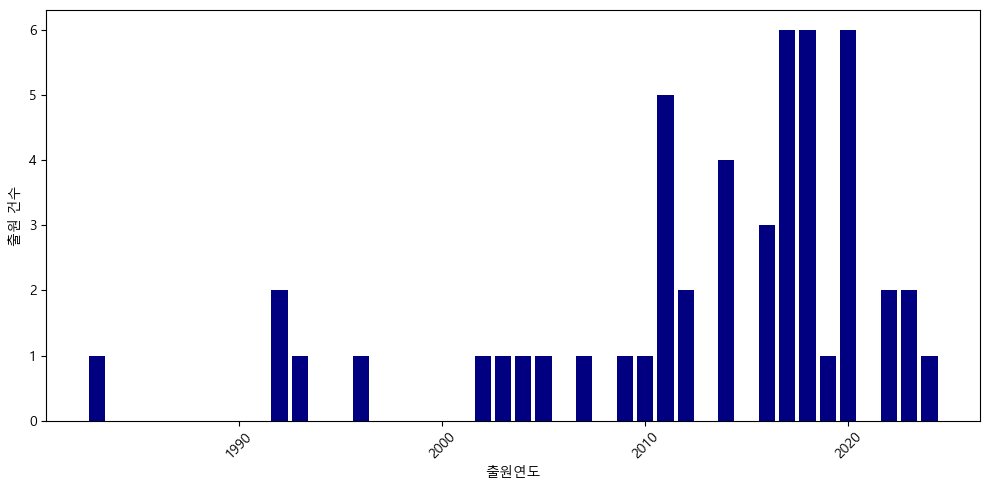


🧠 트렌드 해석 결과:
 태양광 기술 관련 특허 출원 건수를 연도별로 분석하면 다음과 같은 경향성을 볼 수 있습니다:

1. 초기 단계: 1983년부터 2004년까지는 특허 출원이 매우 적었습니다. 이 시기에는 매년 평균적으로 1건 미만의 특허가 출원되었습니다.

2. 성장 시작: 2005년을 기점으로 특허 출원 건수가 증가하기 시작했습니다. 2007년과 2009년에도 각각 1건씩 출원이 이루어졌습니다.

3. 초기 급증: 2011년부터 특허 출원 건수는 급격히 증가하여 5건까지 달했습니다. 이는 태양광 기술의 발전과 함께 시장에서의 중요성이 증가한 결과로 보입니다.

4. 안정화와 다시 증가: 2012년부터 특허 출원 건수는 2~6건 사이에서 안정적으로 유지되다가 2017년부터 다시 급증했습니다. 2017년과 2018년에는 각각 6건의 특허가 출원되었습니다.

5. 최근 동향: 2019년 이후로는 특허 출원 건수가 줄어들었지만, 여전히 꾸준한 수준을 유지하고 있습니다. 2020년에는 6건이而出解析结果：


从提供的数据来看，太阳能技术相关专利申请数量随时间的变化趋势可以总结如下：

1. **初期阶段（1983-2004年）**：在这一时期内，每年的专利申请量非常少，平均每年不到1件。

2. **起步增长期（2005-2010年）**：从2005年开始，专利申请数量逐渐增加。直到2010年，每年的申请量仍然保持在1件左右。

3. **快速增长期（2011-2016年）**：自2011年起，专利申请数量显著增长。特别是在2011年达到了5件的历史高点，之后几年虽然有所波动但总体呈上升趋势。

4. **稳定增长期（2017-2018年）**：从2017年开始，专利申请量再次大幅增加，并在2017和2018年分别达到6件的高峰。这表明该技术领域正在经历快速的技术创新和发展阶段。

5. **近期趋势（2019-至今）**：自2019年以来，尽管专利申请数量有所波动，但总体保持在一个相对稳定的水平上。2020年的申请量为6件，而2022年和2023年分别为2件和2件，2024年则回落到1件。

综上所述，太阳能技术领域的专利活动在经历了初期的缓慢增长后，在最

KeyboardInterrupt: 

In [6]:
result = app.invoke(
    {"input": "현대 자동차가 출원한 특허 중에서, 태양광을 이용하여 이차전지로 전기자동차 충전을 가능하게 하는 관련 특허 기술은 무엇이 있어? 듀얼 배터리 기술에 대한 출원 동향은 어떻게 돼?"},
    config={"configurable": {"thread_id": "demo-thread"}}
)
print("\n📝 전체 실행 로그:")
for i, entry in enumerate(result["log"], 1):
    print(f"\nStep {i}:")
    print(entry)

print("\n📄 최종 결과:")
print(result.get("response", "[응답 없음]"))

In [7]:
result = app.invoke(
    {"input": "태양광을 이용하여 이차전지로 전기자동차 충전을 가능하게 하는 관련 특허 기술이나 듀얼 배터리 기술은 어떤 게 있고 태양광 기술에 대한 출원 동향은 어떻게 돼?"},
    config={"configurable": {"thread_id": "demo-thread"}}
)
print("\n📝 전체 실행 로그:")
for i, entry in enumerate(result["log"], 1):
    print(f"\nStep {i}:")
    print(entry)

print("\n📄 최종 결과:")
print(result.get("response", "[응답 없음]"))

Sub-query 분리 결과: {'patent_searcher': '태양광을 이용하여 이차전지로 전기자동차 충전을 가능하게 하는 관련 특허 기술, 듀얼 배터리 기술', 'patent_trend_analyzer': '태양광 기술에 대한 2020년 이후 출원 동향'}

📘 특허 검색 및 요약 정보:

태양광을 이용하여 이차전지로 전기자동차 충전을 가능하게 하는 관련 특허 기술은 두 가지 주요 발명으로 구성되어 있습니다.

첫 번째 특허는 "계통 전력과 태양광 발전부 및 배터리 관리부의 연계를 통한 전기자동차 충전시스템" (출원번호: KR20230005488A)에 관한 것입니다. 이 발명은 전기차량의 충전이 가능한 에너지 저장 시스템 및 충전장치를 구비하여, 태양광 발전부로 발전된 전원을 이용해 전기차량을 충전할 수 있는 시스템을 제시합니다. 이는 특히 고속도로나 해수욕장 등 충전소가 부족한 장소에서 유용하게 활용될 수 있습니다.

두 번째 특허는 "태양광발전 이동식 전기자동차 충전시스템" (출원번호: KR20230005488A)에 관한 것입니다. 이 발명은 태양광발전을 이용해 이차전지를 충전하고, 이를 통해 전기차량을 충전할 수 있는 시스템을 제시합니다. 이 시스템은 특히 충전소가 부족한 지역이나 격오지 등에서 큰 도움이 될 것으로 기대됩니다.

두 특허 모두 태양광을 이용해 전기차의 이차전지를 충전하는 방안을 제시하며, 각각의 발명은 특정 환경에서 유용하게 활용될 수 있는 장점을 가지고 있습니다. 첫 번째 특허는 주로 고속도로나 관광지 등에서, 두 번째 특허는 일반적인 이동식 충전 시스템에서 태양광을 이용한 전기차 충전 기술을 제공합니다. 이러한 발명들은 전기차의 보급과 함께 대기오염 감소와 에너지 효율성 향상을 위해 중요한 역할을 수행하게 될 것입니다.

 관련 특허 요약 정보:

| 출원번호       | 발명의 명칭                                                                            | 요약

## Tool2

Sub-query 분리 결과: {'patent_trend_analyzer': '배터리 냉각 특허 출원 동향'}


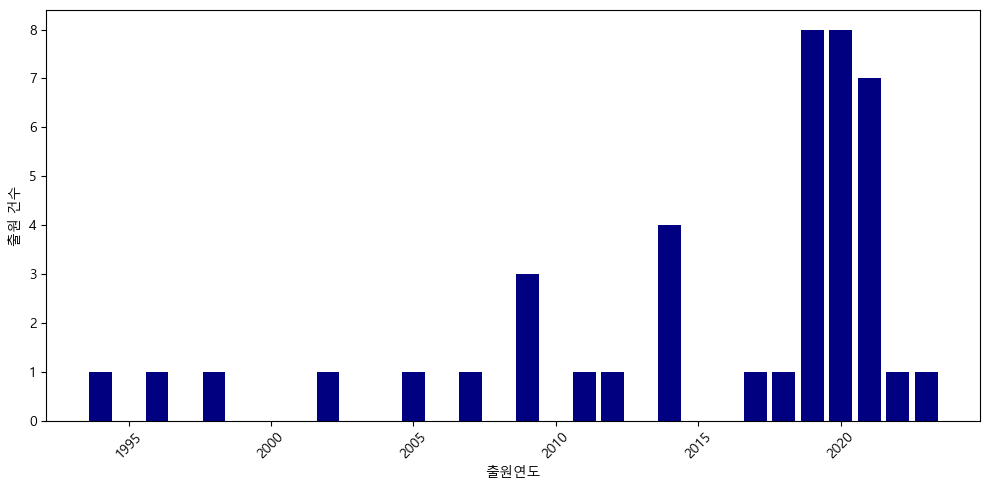


🧠 트렌드 해석 결과:
 이 데이터는 배터리 냉각 기술에 대한 특허 출원 건수를 연도별로 나타낸 것입니다. 분석해보면 다음과 같은 특징들이 있습니다:

1. 초기 단계: 1994년부터 2005년까지는 매년 1건씩만 특허가 출원되었습니다.

2. 성장기: 2007년부터 갑작스럽게 증가하여 2009년에는 3건이 출원되었습니다.

3. 안정적 성장: 2011년부터 2016년까지는 매년 약 1-4건의 특허가 출원되었으며, 이 기간 동안 배터리 냉각 기술에 대한 관심이 꾸준히 증가했습니다.

4. 급격한 성장: 2019년부터는 갑작스럽게 특허 출원 건수가 늘어나기 시작했으며, 2023년까지 매년 7건 이상의 특허가 출원되었습니다.

이 데이터는 배터리 냉각 기술 분야에서 최근 몇 년간 빠른 발전과 관심 증가를 보여줍니다. 특히 전기차와 같은 전기vehicular technology의 성장과 함께 배터리 성능 향상을 위한 다양한 냉각 방법에 대한 연구가 활발해졌음을 시사합니다.

📝 전체 실행 로그:

Step 1:
🔧 선택된 도구: ['patent_searcher', 'patent_evaluator']

Step 2:
🧩 Sub-query 분리 결과: {'patent_searcher': '현대케피코가 2020년 이후에 출원한 최적 운전점을 정하는 방법, 엔진 토크 효율 관리', 'patent_evaluator': '엔진 토크 효율 관리'}

Step 3:
⚙️ 실행 완료: ['patent_searcher', 'patent_evaluator']

Step 4:
🧠 최종 종합 요약 완료

Step 5:
🔧 선택된 도구: ['patent_searcher', 'patent_evaluator']

Step 6:
🧩 Sub-query 분리 결과: {'patent_searcher': '높은 기울기 상태에서 급출발시 차량 밀림 현상이 발생할 수 있는 개선 기술', 'patent_evaluator': '차량 밀림 현상을 보완한 기술'}

Step 7:
⚙️ 실행 완료: ['paten

In [9]:
result = app.invoke(
    {"input": "배터리 냉각 특허 출원 동향은 어떻게 돼?"},
    config={"configurable": {"thread_id": "demo-thread"}}
)
print("\n📝 전체 실행 로그:")
for i, entry in enumerate(result["log"], 1):
    print(f"\nStep {i}:")
    print(entry)

print("\n📄 최종 결과:")
print(result.get("response", "[응답 없음]"))

## Tool3

In [ ]:
result = app.invoke(
    {"input": "배터리 냉각 특허 관련 중요 특허 평가해줘"},
    config={"configurable": {"thread_id": "demo-thread"}}
)
print("\n📝 전체 실행 로그:")
for i, entry in enumerate(result["log"], 1):
    print(f"\nStep {i}:")
    print(entry)

print("\n📄 최종 결과:")
print(result.get("response", "[응답 없음]"))

Sub-query 분리 결과: {'patent_searcher': '배터리 냉각 특허, 배터리 효율 개선 기술', 'patent_evaluator': '배터리 냉각'}


In [13]:
result = app.invoke(
    {"input": "기술 명세서 초안작성 도와줘"},
    config={"configurable": {"thread_id": "demo-thread"}}
)
print("\n📝 전체 실행 로그:")
for i, entry in enumerate(result["log"], 1):
    print(f"\nStep {i}:")
    print(entry)

print("\n📄 최종 결과:")
print(result.get("response", "[응답 없음]"))

Sub-query 분리 결과: {'tech_writer': '기술 명세서 초안작성'}
📝 기술 설명서를 위한 초안 작성을 시작합니다.
다음은 초안작성 도우미 가이드라인입니다. 부족한 항목에 대해서 명시해드리니, 해당항목에 대해서만 추가 입력해주시면 됩니다.

📌 누락된 항목: 해결하고자 하는 문제, 발명 과정, 기대 효과
다음은 초안작성 도우미 가이드라인입니다. 부족한 항목에 대해서 명시해드리니, 해당항목에 대해서만 추가 입력해주시면 됩니다.

📌 누락된 항목: 해결하고자 하는 문제, 발명 과정, 발명 내용
다음은 초안작성 도우미 가이드라인입니다. 부족한 항목에 대해서 명시해드리니, 해당항목에 대해서만 추가 입력해주시면 됩니다.

📝 전체 실행 로그:

Step 1:
🔧 선택된 도구: ['patent_trend_analyzer']

Step 2:
🧩 Sub-query 분리 결과: {'patent_trend_analyzer': '현대자동차의 무선 배터리 충전 시스템 관련 2020년 이후 출원 동향'}

Step 3:
⚙️ 실행 완료: ['patent_trend_analyzer']

Step 4:
🧠 최종 종합 요약 완료

Step 5:
🔧 선택된 도구: ['patent_trend_analyzer']

Step 6:
🧩 Sub-query 분리 결과: {'patent_trend_analyzer': '현대자동차의 배터리 냉각 특허 출원 동향'}

Step 7:
⚙️ 실행 완료: ['patent_trend_analyzer']

Step 8:
🧠 최종 종합 요약 완료

Step 9:
🔧 선택된 도구: ['patent_trend_analyzer']

Step 10:
🧩 Sub-query 분리 결과: {'patent_trend_analyzer': '배터리 냉각 특허 출원 동향'}

Step 11:
⚙️ 실행 완료: ['patent_trend_analyzer']

Step 12:
🧠 최종 종합 요약 완료

Step 13:
🔧 선택된 도구: ['patent_searcher', 

In [6]:
result = app.invoke(
    {"input": "전기차에서 내연기관차가 제공하는 승차감을 제공하고 스포티한 느낌을 줄 수 있도록 나온 기술 있나? 변속감을 제어하기 위한 내용이어도 좋아"},
    config={"configurable": {"thread_id": "demo-thread"}}
)
print("\n📝 전체 실행 로그:")
for i, entry in enumerate(result["log"], 1):
    print(f"\nStep {i}:")
    print(entry)

print("\n📄 최종 결과:")
print(result.get("response", "[응답 없음]"))

Sub-query 분리 결과: {'patent_searcher': '변속감을 제어하기 위한 내용'}

🔍 [Tool1-1] 서브 쿼리 실행 중: 변속감을 제어하기 위한 내용
🔍 추론된 필터 조건: {}

🔎 총 retrieval 문서 수: 10개
[🔹 Retrieved 1] KR20237023364A | 로베르트 보쉬 게엠베하 | 충전 포트 커버를 제어하는 장치 및 방법, 그리고 전기차 | Section: 기술배경
[🔹 Retrieved 2] KR20200166379A | 현대자동차 | 전동화 차량의 변속 제어방법 | Section: 기술과제
[🔹 Retrieved 3] KR20200070004A | 현대자동차 | 전기자동차의 주행 제어 방법 | Section: 요약
[🔹 Retrieved 4] KR20200070004A | 현대자동차 | 전기자동차의 주행 제어 방법 | Section: 기술과제
[🔹 Retrieved 5] KR20190165336A | 브이씨텍 경기 군포시 엘에스로45번길 107, (당정동) | 상용 전기차의 토크 지령 생성 방법 | Section: 기술과제
[🔹 Retrieved 6] KR20170147148A | 르노삼성자동차 | 전기 자동차에서 변속감을 표현하기 위한 방법 | Section: 기술과제
[🔹 Retrieved 7] KR20170018401A | 현대자동차 | 전기자동차의 변속 제어 방법 | Section: 요약
[🔹 Retrieved 8] KR20170018401A | 현대자동차 | 전기자동차의 변속 제어 방법 | Section: 발명의효과
[🔹 Retrieved 9] KR20170018401A | 현대자동차 | 전기자동차의 변속 제어 방법 | Section: 기술배경
[🔹 Retrieved 10] KR20160128794A | 현대자동차 | 하이브리드 차량의 제어 방법 | Section: 기술과제

✅ 필터링 적용 후 문서 수: 10개
[🔸 Filtered 1] KR20237023364A | 로베르트 보쉬 게엠베하 | 충